# Image Classification using Neural Networks
#### Team members: Amna Gul, Bin Xing, Ke Zhou 

# 1. Introduction 

Since the rise of the smartphone, the amount of data has spiked and is still increasing rapidly, particularly image data.  Smartphones let people capture pictures anytime, anywhere, to share either with family or on social media.  Research conducted by David Carrington predicted that 1.4 billion photos would be taken in 2020 (Carrington, 2020).  While browsing these photos, it is easy for a human to identify whether the selected picture depicts a human, object, or scenery.  However, it is a challenging task to instruct a machine to tackle the same classification problem.

People can differentiate an image with only a glance due to the nature of our brain.  Therefore, the project aims to tackle the image classification problem using neural network techniques and study whether image variation in grayscale and RGB could impact the classification process.  We chose the Intel Image Classification data set from Kaggle. This dataset contains over 25,000 total images of size 150 x 150 pixels. Among them, 14,034 are labeled as training data in six categories: mountain, street, glacier, building, sea, and forest. Twenty percent of the training data is split out as the validation set.  Also, 3,000 images are testing data, and 7,000 are for prediction use.

### Preparation
### Import Packages

In [0]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras import optimizers
from keras.optimizers import adam
from matplotlib import pyplot
import pickle
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Create Labels for Images

In [0]:
# There are 6 categories of images in the dataset
categories = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

# Create label for each category of images
categories_label = {category:i for i, category in enumerate(categories)}
categories_label

{'buildings': 3,
 'forest': 5,
 'glacier': 2,
 'mountain': 0,
 'sea': 4,
 'street': 1}

In [0]:
num_categories = len(categories)
print('There are {} categories of images.'.format(num_categories))

There are 6 categories of images.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'Colab'/'Final_ML1'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab/Final_ML1


In [0]:
# reload saved data at later time but first uncomment the above code so that it does not rerun
pickle_in = open('train_images.pickle', 'rb')
train_images = pickle.load(pickle_in)

pickle_in = open('train_labels.pickle', 'rb')
train_labels = pickle.load(pickle_in)

pickle_in = open('test_images.pickle', 'rb')
test_images = pickle.load(pickle_in)

pickle_in = open('test_labels.pickle', 'rb')
test_labels = pickle.load(pickle_in)

#### Explore the Dataset
#### Plot categories of RGB images in Training set

Text(0.5, 1.0, 'Counts for Each Categories')

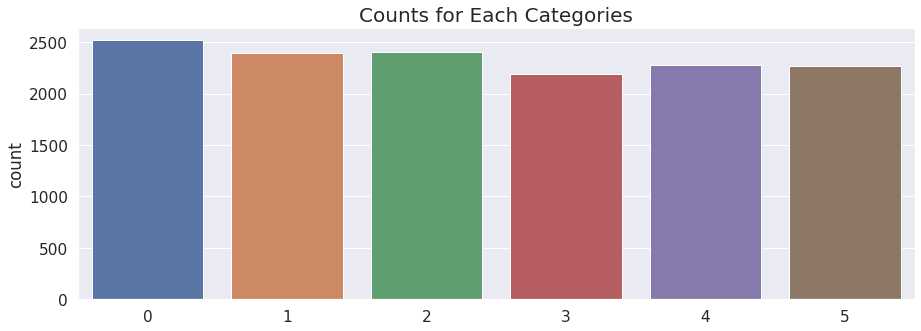

In [0]:
# Plot the counts 
X = np.array(train_images)
Y = np.array(train_labels)

# Plot the data of each categories
plt.figure(figsize=(15,5))
sns.countplot(Y)
plt.title('Counts for Each Categories', loc= 'center', fontsize = 20)

#### Plot categories of RGB images in Test set

In [0]:
# Below we created a function to plot how many images in each category
def plot_data(name, target):
    _, target_counts = np.unique(target, return_counts=True)
    pd.DataFrame({'{}'.format(name):target_counts},
                 index=categories_label).plot.bar()
    plt.show()



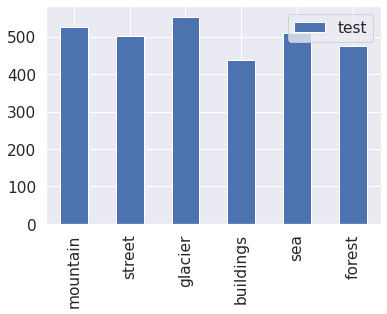

In [0]:
# Plot the the number of images in each category in the testing set
plot_data('test', test_labels)

# 2. Model Design
## 2.1 Grayscale Images

#### Breaking down the process of model building

1. Loading (& Preprocessing) the data
2. Defining Model architecture
3. Training the Model
4. Evaluating Performance


#### Converting Images to Grayscale & Assigning Labels

There are two main reasons for converting our images to Grayscale:

1. We believe that most important component in image classification are features like edges (not the color)
2. Grayscale images offer reduced processing time & space


In [0]:
def import_images():
    directories = ['./Intel_Data/Train', './Intel_Data/Test']
    img_data = []
    for directory in directories: 
        images = []
        labels = []
        for folder in os.listdir(directory):
            label = categories_label[folder]
            for file in tqdm(os.listdir(os.path.join(directory, folder))):
                img_path = os.path.join(os.path.join(directory, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting to grayscale
                image_size = (150, 150)   # defining image size
                image = cv2.resize(image, image_size) 
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')           
        img_data.append((images, labels))
    return img_data

In [0]:
(train_images, train_labels), (test_images, test_labels) = import_images()

100%|██████████| 525/525 [04:23<00:00,  1.99it/s]


#### Preprocessing
Three preprocessing techniques that we are going to apply are:
1. Resizing all images (already done while loading data)
2. Shuffling the training set
3. Normalizing both training & test images


In [0]:
# shuffling
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

In [0]:
# normalizing
train_images = train_images/255
test_images = test_images/255

#### Pickling

In [0]:
# # saving train data using pickle
# pickle_out = open('train_images.pickle', 'wb')   # write in bytes
# pickle.dump(train_images, pickle_out)
# pickle_out.close()

# pickle_out = open('train_labels.pickle', 'wb')
# pickle.dump(train_labels, pickle_out)
# pickle_out.close()

# # saving test data using pickle
# pickle_out = open('test_images.pickle', 'wb')   # write in bytes
# pickle.dump(test_images, pickle_out)
# pickle_out.close()

# pickle_out = open('test_labels.pickle', 'wb')
# pickle.dump(test_labels, pickle_out)
# pickle_out.close()

#### Verifying that data is Grayscale

In [0]:
# Dimension of array is 2D
train_images[0]

array([[0.41960785, 0.27450982, 0.39607844, ..., 0.43529412, 0.3372549 ,
        0.3882353 ],
       [0.28235295, 0.3019608 , 0.44705883, ..., 0.41960785, 0.3764706 ,
        0.40392157],
       [0.27450982, 0.27450982, 0.43137255, ..., 0.41960785, 0.37254903,
        0.40784314],
       ...,
       [0.41568628, 0.5921569 , 0.5764706 , ..., 0.22745098, 0.29803923,
        0.3254902 ],
       [0.5137255 , 0.5058824 , 0.54509807, ..., 0.27058825, 0.30980393,
        0.23137255],
       [0.4392157 , 0.38431373, 0.2901961 , ..., 0.22745098, 0.2784314 ,
        0.18039216]], dtype=float32)

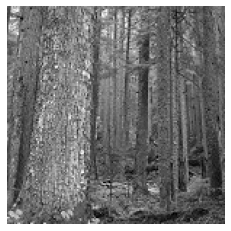

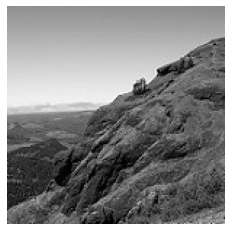

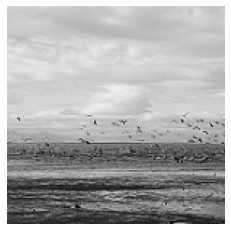

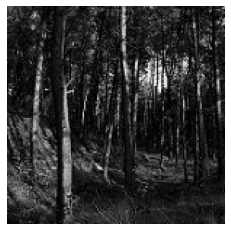

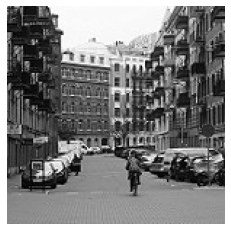

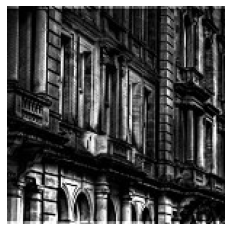

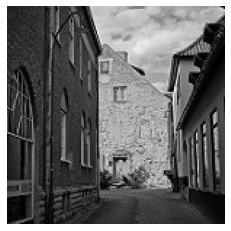

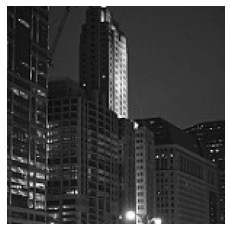

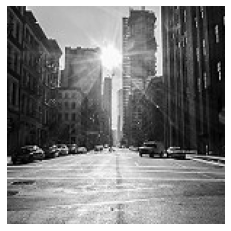

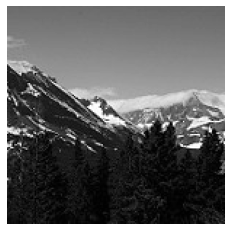

In [0]:
# displaying first 10 images in train set
for i in range(10):
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
  plt.show()

## Model 1 - Traditional Neural Network Model on Grayscale images

Step 1 Defining the NN model

In [0]:
# A sequential dnn with two hidden layers
model_traditional = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[150, 150,1]),  # adding input layer
        tf.keras.layers.Dense(32, activation="relu"),       # hidden layer
        tf.keras.layers.Dense(32, activation="relu"),       # hidden layer
        tf.keras.layers.Dense(6, activation="softmax")])  # 6 classes

model_traditional.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                720032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 721,286
Trainable params: 721,286
Non-trainable params: 0
_________________________________________________________________


2- Compiling the Neural Network with SGD as optimizer

In [0]:
# Compile the model, specify hyperparameters such as loss function, optimizer and evaluation metrics.
model_traditional.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

3- Training the Neural Network

In [0]:
# Train and evaluate the model
result_model_traditional = model_traditional.fit(train_images, 
                                           train_labels, 
                                           batch_size = 32,
                                           epochs=10, 
                                           validation_split = 0.2)

Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.7162 - accuracy: 0.2574 - val_loss: 1.8064 - val_accuracy: 0.2516
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5969 - accuracy: 0.3342 - val_loss: 1.6302 - val_accuracy: 0.3203
Epoch 3/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5588 - accuracy: 0.3574 - val_loss: 1.5951 - val_accuracy: 0.3249
Epoch 4/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5294 - accuracy: 0.3768 - val_loss: 1.5223 - val_accuracy: 0.3893
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 1.4960 - accuracy: 0.4027 - val_loss: 1.5766 - val_accuracy: 0.3694
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 1.4621 - accuracy: 0.4188 - val_loss: 1.5776 - val_accuracy: 0.3626
Epoch 7/10
352/352 [==============================] - 2s 6ms/step - loss: 1.4418 - accuracy: 0.4270 - val_loss: 1.5184 - val_accuracy: 0.3879
Epoch 

Visualizing the performance of model on training data

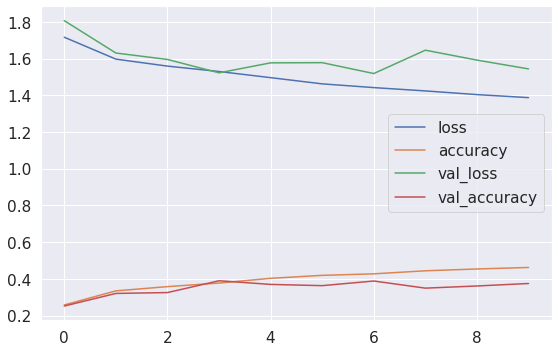

In [0]:
# Visualizing the performance of model on training data
import pandas as pd

# Create a figure
pd.DataFrame(result_model_traditional.history).plot(figsize=(8, 5))

# Show the figure
plt.tight_layout()
plt.show()

4- Evaluating the Neural Network

In [0]:
loss, accuracy = model_traditional.evaluate(test_images, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 1.5385 - accuracy: 0.3733


## Model 2 - Traditional Neural Network with 'adam' as optimizer on Grayscale Images

In [0]:
# Defining a sequential dnn with two hidden layers
model_traditional_adam = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[150, 150,1]),  # adding input layer
        tf.keras.layers.Dense(32, activation="relu"),       # hidden layer
        tf.keras.layers.Dense(32, activation="relu"),       # hidden layer
        tf.keras.layers.Dense(6, activation="softmax")])  # 3 classes

# model_traditional.summary()

In [0]:
# Compiling
model_traditional_adam.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Train the model
result_model_traditional_adam = model_traditional_adam.fit(train_images, 
                                           train_labels, 
                                           batch_size = 32,
                                           epochs=10, 
                                           validation_split = 0.2)

Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.7639 - accuracy: 0.2987 - val_loss: 1.8147 - val_accuracy: 0.2459
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6059 - accuracy: 0.3512 - val_loss: 1.6695 - val_accuracy: 0.2904
Epoch 3/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5392 - accuracy: 0.3816 - val_loss: 1.6779 - val_accuracy: 0.3292
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5097 - accuracy: 0.4013 - val_loss: 1.5485 - val_accuracy: 0.3886
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 1.4685 - accuracy: 0.4211 - val_loss: 1.5795 - val_accuracy: 0.3694
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 1.4571 - accuracy: 0.4316 - val_loss: 1.5619 - val_accuracy: 0.3623
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 1.4304 - accuracy: 0.4398 - val_loss: 1.5158 - val_accuracy: 0.3907
Epoch 

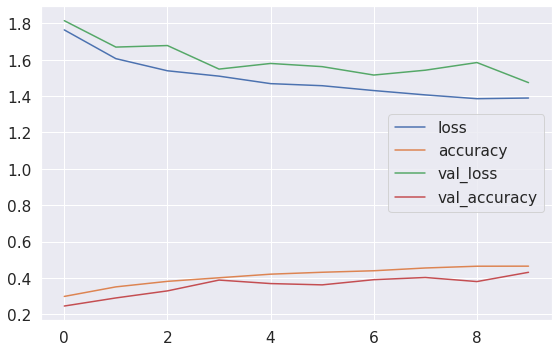

In [0]:
# Visualizing the performance of model on training data
import pandas as pd

# Create a figure
pd.DataFrame(result_model_traditional_adam.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.show()

In [0]:
# Evaluate the model
loss, accuracy = model_traditional_adam.evaluate(test_images, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 1.4688 - accuracy: 0.4350


## Model 3 - Convolution Neural Network on Grayscale Images

In [0]:
# Defining the model
model_convolution = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = [150, 150, 1]), 
    tf.keras.layers.MaxPooling2D((3,3)),

    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_convolution.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               921728    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [0]:
#reshaping images (adding dimension)
train_images = train_images.reshape(14048,150,150,1)
test_images = test_images.reshape(3000,150,150,1)

In [0]:
# Compiling
model_convolution.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Training
result_model_convolution = model_convolution.fit(train_images, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
352/352 [==============================] - 4s 10ms/step - loss: 1.0829 - accuracy: 0.5815 - val_loss: 0.8175 - val_accuracy: 0.6950
Epoch 2/10
352/352 [==============================] - 3s 9ms/step - loss: 0.7455 - accuracy: 0.7243 - val_loss: 0.6966 - val_accuracy: 0.7434
Epoch 3/10
352/352 [==============================] - 3s 9ms/step - loss: 0.6389 - accuracy: 0.7663 - val_loss: 0.6449 - val_accuracy: 0.7715
Epoch 4/10
352/352 [==============================] - 3s 9ms/step - loss: 0.5703 - accuracy: 0.7929 - val_loss: 0.6818 - val_accuracy: 0.7488
Epoch 5/10
352/352 [==============================] - 3s 9ms/step - loss: 0.4868 - accuracy: 0.8298 - val_loss: 0.6730 - val_accuracy: 0.7619
Epoch 6/10
352/352 [==============================] - 3s 9ms/step - loss: 0.4216 - accuracy: 0.8485 - val_loss: 0.7215 - val_accuracy: 0.7505
Epoch 7/10
352/352 [==============================] - 3s 9ms/step - loss: 0.3561 - accuracy: 0.8754 - val_loss: 0.7027 - val_accuracy: 0.7648
Epoch

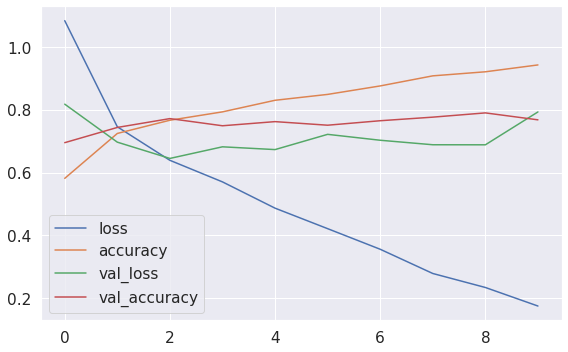

In [0]:
# Visualizing the performance of model on training data
import pandas as pd

# Create a figure
pd.DataFrame(result_model_convolution.history).plot(figsize=(8, 5))

plt.tight_layout()
plt.show()

In [0]:
loss, accuracy = model_convolution.evaluate(test_images, test_labels)

94/94 [==============================] - 0s 5ms/step - loss: 0.8347 - accuracy: 0.7647


# 2.2 RGB Images
#### Import RGB Data

In [0]:
# Below we created a function to import images from both the training and testing sets using opencv library
# While importing the images, labels of the images were appended to the images.
def import_images():
    directories = ['/Users/sa/Desktop/intel-image-classification/seg_train/seg_train', '/Users/sa/Desktop/intel-image-classification/seg_test/seg_test']
    img_data = []
    for directory in directories: 
        images = []
        labels = []
        for folder in os.listdir(directory):
            label = categories_label[folder]
            for file in tqdm(os.listdir(os.path.join(directory, folder))):
                img_path = os.path.join(os.path.join(directory, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_size = (150, 150)
                image = cv2.resize(image, image_size) 
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')           
        img_data.append((images, labels))
    return img_data

In [0]:
# import the images from training and testing datasets
(train_images, train_labels), (test_images, test_labels) = import_images()

100%|██████████| 510/510 [00:00<00:00, 590.39it/s]


In [0]:
# To gain better training results, we shuffled the training images
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

In [0]:
# Normalize the images for further analysis
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [0]:
# The number of images in training set
n_train = train_labels.shape[0]
print('There are {} training images.'.format(n_train))

There are 14034 training images.


In [0]:
# The number of images in testing set
n_test = test_labels.shape[0]
print('There are {} testing images.'.format(n_test))

There are 3000 testing images.


#### Inspect the Images

In [0]:
# Reference from Tensorflow 
# Link: https://www.tensorflow.org/tutorials/images/classification
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        #ax.axis('off')
    plt.tight_layout()
    plt.show()

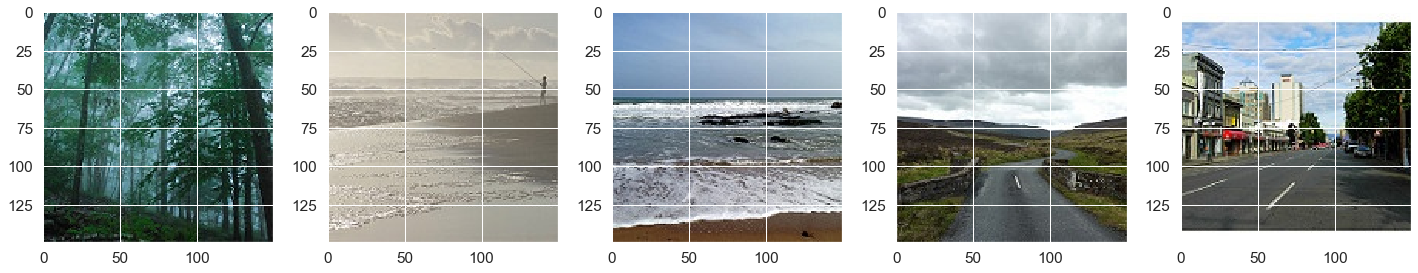

In [0]:
# Display the images
plotImages(train_images[:5])

## Model 4 - Deep Neural Network Model on RGB Images

In this section model 4 and 5, the pre-processed RGB images feed into the deep neural network and the convolution neural network used for training image data using Keras from Tensorflow.  For the deep neural network, the two-layered model consists of two hidden layers, with ReLU and one output layer using Softmax activation.  While compiling the model, the optimizer opts for Adam, since it takes significantly less time to run, but achieves a higher accuracy.  The accuracy, according to testing data, is 53%.  

Then, to increase the accuracy, the RGB images are also tested on the convolution neural network using the same parameters as the previous deep neural network.  The CNN model starts with a simple structure without the dropout layer, and it results in overfitting.  To counteract the overfitting problems, the dropout layer experiments with different parameters, and the best outcome with least overfitting is 74% accuracy.   

In conclusion, the convolution neural network does lead to higher accuracy.  However, it is sensitive in the training process and has a higher tendency of overfitting.  Further works are expected to enhance the CNN model design for higher accuracy on image classification matters.  


In [0]:
# Basic deelp neural network
model_basic = tf.keras.models.Sequential([
    # Input flatten layer
    tf.keras.layers.Flatten(input_shape=[150, 150,3]),
    
    # Hindden layer
    tf.keras.layers.Dense(300, activation="relu"), # 150*150*3*256
    tf.keras.layers.Dense(100, activation="relu"),

    # Output layer 
    tf.keras.layers.Dense(6, activation="softmax")
])
model_basic.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               20250300  
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 606       
Total params: 20,281,006
Trainable params: 20,281,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model
model_basic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), # Tuning the learning rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [0]:
# Train the model
history = model_basic.fit(train_images,train_labels,
                    epochs=8, batch_size =128,
                    validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/8
11227/11227 [==============================] - 41s 4ms/sample - loss: 8.7068 - accuracy: 0.3148 - val_loss: 2.0808 - val_accuracy: 0.4724
Epoch 2/8
11227/11227 [==============================] - 24s 2ms/sample - loss: 2.8313 - accuracy: 0.3899 - val_loss: 2.7678 - val_accuracy: 0.4111
Epoch 3/8
11227/11227 [==============================] - 19s 2ms/sample - loss: 1.8823 - accuracy: 0.4503 - val_loss: 2.2299 - val_accuracy: 0.3513
Epoch 4/8
11227/11227 [==============================] - 22s 2ms/sample - loss: 1.6835 - accuracy: 0.4658 - val_loss: 2.1183 - val_accuracy: 0.4186
Epoch 5/8
11227/11227 [==============================] - 22s 2ms/sample - loss: 1.5597 - accuracy: 0.4817 - val_loss: 1.3674 - val_accuracy: 0.5198
Epoch 6/8
11227/11227 [==============================] - 17s 2ms/sample - loss: 1.3264 - accuracy: 0.5274 - val_loss: 1.3612 - val_accuracy: 0.5112
Epoch 7/8
11227/11227 [==============================] - 18s 2m

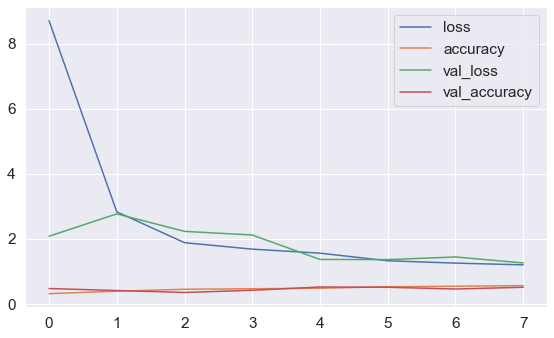

In [0]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Show the figure
plt.tight_layout()
plt.show()

In [0]:
# Evaluate the model on testing data
model_basic.evaluate(test_images, test_labels)

3000/3000 [==============================] - 5s 2ms/sample - loss: 1.3140 - accuracy: 0.5047


[1.3139571154912313, 0.5046667]

## Model 5 - Convolution Neural Network on RGB Images

In [0]:
# Build the cnn model 
model_cnn = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same', 
                        input_shape=[150, 150, 3]),
    
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Output layer
    tf.keras.layers.Dense(6, activation='softmax')
])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                11520064  
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
Total params: 11,522,886
Trainable params: 11,522,886
Non-trainable params: 0
__________________________________________

In [0]:
# Compile the model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(), # Tuning the learning rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [0]:
# Train the cnn model with same spochs and batch size 
history_cnn = model_cnn.fit(train_images,train_labels,
                            epochs=8, batch_size = 128,
                            validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/8
11227/11227 [==============================] - 182s 16ms/sample - loss: 2.2742 - accuracy: 0.2765 - val_loss: 1.5512 - val_accuracy: 0.4279
Epoch 2/8
11227/11227 [==============================] - 136s 12ms/sample - loss: 1.4858 - accuracy: 0.3734 - val_loss: 1.3090 - val_accuracy: 0.5625
Epoch 3/8
11227/11227 [==============================] - 157s 14ms/sample - loss: 1.3892 - accuracy: 0.4122 - val_loss: 1.2145 - val_accuracy: 0.5885
Epoch 4/8
11227/11227 [==============================] - 150s 13ms/sample - loss: 1.3075 - accuracy: 0.4449 - val_loss: 1.1031 - val_accuracy: 0.5736
Epoch 5/8
11227/11227 [==============================] - 164s 15ms/sample - loss: 1.2526 - accuracy: 0.4620 - val_loss: 1.0620 - val_accuracy: 0.6117
Epoch 6/8
11227/11227 [==============================] - 131s 12ms/sample - loss: 1.1701 - accuracy: 0.4927 - val_loss: 1.0551 - val_accuracy: 0.5953
Epoch 7/8
11227/11227 [============================

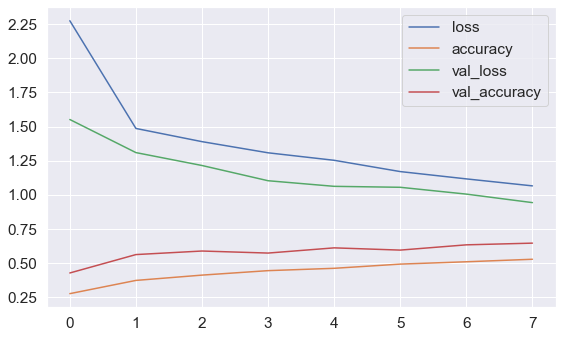

In [0]:
# Create a figure
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))

# Show the figure
plt.tight_layout()
plt.show()

In [0]:
# Evaluate the model on testing set
model_cnn.evaluate(test_images, test_labels)

3000/3000 [==============================] - 10s 3ms/sample - loss: 0.9507 - accuracy: 0.6420


[0.9506536819140117, 0.642]

### Convolutional Neural Network (CNN) 

The convolutional neural network (CNN) is a class of deep learning neural networks and is most commonly used to analyze visual imagery and image classification. Here we use CNN to classify our images.

Below we trained three models:

1. CNN with 2 Convolutional Layer
2. CNN with 6 Convolutional Layer
3. VGG-16 Pre-Trained Model

The training of each model follows below steps:

1. Build the model,
2. Compile the model,
3. Fit the training data to the model,
4. Evaluate the model on the validating data.
5. evalue the model producing the best accuracy score (on the validating data) using the testing data.

## Model 6 - Convolution Neural Network on RGB Images

In [0]:
# We first built a relatively simple model composed of following layers:
model = tf.keras.Sequential([
    # Conv2D layer (32 filters of size 3 by 3) which extracted features from the images. 
    # Relu layer which given a value x, returned max(x, 0). 
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    # MaxPooling2D layer which downsample the images. 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten layer which transformed the format of the images from a 2d-array 
    # to a 1d-array of 150 150 3 pixel values. 
    tf.keras.layers.Flatten(),
    # Dense layer which fully connected previous layers with output layer
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    # Softmax layer which classified the images into one of 6 categories.
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [0]:
# Compile the model
# We chose 'adam'  as the optimizer because it generally produces the best accuracy results 
# according to literature.
# We chose 'sparse_categorical_crossentropy' because it used when classifying multiple classes.
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Split the training data into training and validating sets
# Fit the model to training data
# Evalute the model on validating data
result = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 189s 17ms/sample - loss: 1.1838 - accuracy: 0.5676 - val_loss: 0.8674 - val_accuracy: 0.6854
Epoch 2/10
11227/11227 [==============================] - 155s 14ms/sample - loss: 0.7352 - accuracy: 0.7286 - val_loss: 0.7224 - val_accuracy: 0.7325
Epoch 3/10
11227/11227 [==============================] - 149s 13ms/sample - loss: 0.5605 - accuracy: 0.8007 - val_loss: 0.8134 - val_accuracy: 0.7082
Epoch 4/10
11227/11227 [==============================] - 151s 13ms/sample - loss: 0.4285 - accuracy: 0.8560 - val_loss: 0.6520 - val_accuracy: 0.7677
Epoch 5/10
11227/11227 [==============================] - 146s 13ms/sample - loss: 0.2922 - accuracy: 0.9056 - val_loss: 0.6805 - val_accuracy: 0.7716
Epoch 6/10
11227/11227 [==============================] - 146s 13ms/sample - loss: 0.2025 - accuracy: 0.9415 - val_loss: 0.7372 - val_accuracy: 0.7745
Epoch 7/10
11227/11227 [=====================

In [0]:
# Check the accuracy rates of the model
_, train_acc = model.evaluate(train_images, train_labels, verbose=0)
_, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.949, Test: 0.747


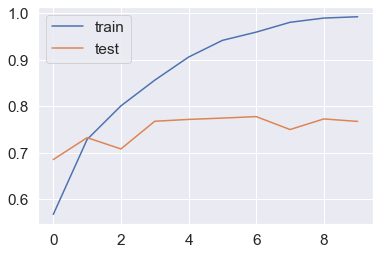

In [0]:
# Plot the accuracy rates
pyplot.plot(result.history['accuracy'], label='train')
pyplot.plot(result.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

From the above plot, we can see that the test accuracy was not improving after 3 spochs. This model overfitted the training data and did not predict images in the test set well.

# Model 7 - Convolution Neural Network on RGB Images

In [0]:
# We then built a more complext CNN model with more layers and filters
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(200, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu'),
    tf.keras.layers.Conv2D(50, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [0]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Split the training data into training and validating sets
# Fit the model to training data
# Evalute the model on validating data
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 3531s 314ms/sample - loss: 1.2119 - accuracy: 0.5042 - val_loss: 0.9007 - val_accuracy: 0.6505
Epoch 2/10
11227/11227 [==============================] - 3538s 315ms/sample - loss: 0.8740 - accuracy: 0.6442 - val_loss: 0.7980 - val_accuracy: 0.6869
Epoch 3/10
11227/11227 [==============================] - 3552s 316ms/sample - loss: 0.7468 - accuracy: 0.7091 - val_loss: 0.7089 - val_accuracy: 0.7328
Epoch 4/10
11227/11227 [==============================] - 3539s 315ms/sample - loss: 0.5991 - accuracy: 0.7753 - val_loss: 0.6576 - val_accuracy: 0.7542
Epoch 5/10
11227/11227 [==============================] - 3535s 315ms/sample - loss: 0.4874 - accuracy: 0.8227 - val_loss: 0.6676 - val_accuracy: 0.7574
Epoch 6/10
11227/11227 [==============================] - 3529s 314ms/sample - loss: 0.3614 - accuracy: 0.8706 - val_loss: 0.6591 - val_accuracy: 0.7934
Epoch 7/10
11227/11227 [=========

In [0]:
# Check the accurarcy on the test data
_, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(test_acc)

0.7776667


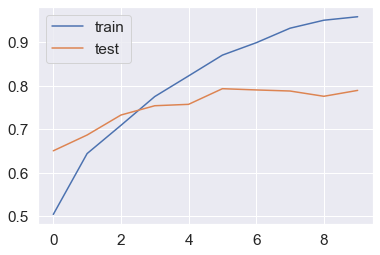

In [0]:
# Plot the accuracy rates
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

From the above plot we can see that the second CNN model achieved a better accuracy score (77.77%). But after 5 spochs, the test accuracy rate ceased to improve. There was still an overfitting issue within this model.

# Predict the Categories of Images using Model 7 

In [0]:
# Because the second CNN model performed better on the testing data, we use it to make predictions.
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 

In [0]:
# We built a function to visualize the result of prediction and the corresponding image
def predict_img(categories, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + categories[labels[index]])
    plt.show()

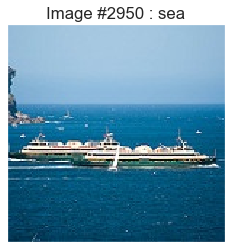

In [0]:
# Below we used CNN Model 2 to predict the categories of 3 random images
# The 1st prediction
predict_img(categories, test_images, pred_labels)

The CNN Model 2 correctly predicted the category of the image.

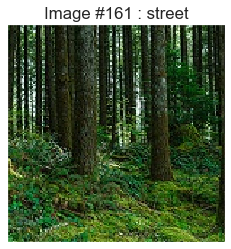

In [0]:
# The 2nd prediction
predict_img(categories, test_images, pred_labels)

The CNN Model 2 predicted the category of the image wrong.

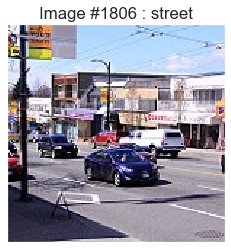

In [0]:
# The 3rd prediction
predict_img(categories, test_images, pred_labels)

The CNN Model 2 correctly predicted the category of the image.

As can be seen from above, CNN Model 2 predicted the category of two of the three images correctly.

# Model 8 - Transfer Learning: VGG16 on RGB Images

A pre-trained network is a saved network that was previously trained on a large dataset. Here we tried to implement pre-trained VGG16

In [0]:
# Load more packages
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

# Set input image dimensions
img_rows, img_cols, img_channel = 150, 150, 3

# Load VGG16 model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [0]:
# Add more layers to VGG16
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(6, activation='softmax'))

# Compile the model
model16 = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model16.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# View the structure of the model
model16.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
# Load more packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# Train the model
batch_size = 128
epochs = 10

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(train_images)


history16 = model16.fit_generator(
    train_datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=train_images.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(test_images, test_labels),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/10
109/109 [==============================] - 6245s 57s/step - loss: 1.2181 - accuracy: 0.5017 - val_loss: 0.9473 - val_accuracy: 0.6093
Epoch 2/10


/Users/sa/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


109/109 [==============================] - 6222s 57s/step - loss: 1.0041 - accuracy: 0.5933 - val_loss: 0.8392 - val_accuracy: 0.6567
Epoch 3/10
109/109 [==============================] - 5758s 53s/step - loss: 0.9386 - accuracy: 0.6302 - val_loss: 0.7793 - val_accuracy: 0.6987
Epoch 4/10
109/109 [==============================] - 5884s 54s/step - loss: 0.7541 - accuracy: 0.7139 - val_loss: 0.6775 - val_accuracy: 0.7420
Epoch 5/10
109/109 [==============================] - 5685s 52s/step - loss: 0.6558 - accuracy: 0.7587 - val_loss: 0.5825 - val_accuracy: 0.7863
Epoch 6/10
109/109 [==============================] - 5645s 52s/step - loss: 0.5699 - accuracy: 0.7936 - val_loss: 0.4717 - val_accuracy: 0.8307
Epoch 7/10
109/109 [==============================] - 5551s 51s/step - loss: 0.5386 - accuracy: 0.8077 - val_loss: 0.4961 - val_accuracy: 0.8180
Epoch 8/10
109/109 [==============================] - 5283s 48s/step - loss: 0.5198 - accuracy: 0.8135 - val_loss: 0.4400 - val_accuracy: 0.8

In [0]:
# Check the accurarcy on the test data
_, test_acc = model16.evaluate(test_images, test_labels, verbose=0)
print(test_acc)

0.8523333072662354


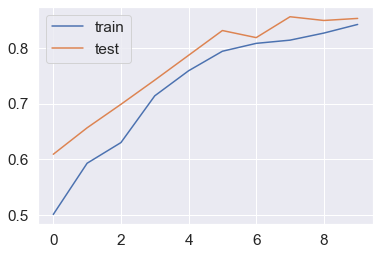

In [0]:
# Plot the accuracy rates
pyplot.plot(history16.history['accuracy'], label='train')
pyplot.plot(history16.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

As can be seen from the plot, the VGG16 model's training and testing accuracy rates kept improving during the 10 epoics. There was no significant overfittnig issue. It is possible that the accuracy rates would get even higher if we had time to run more epoics.

# Predict the Categories of Images using Model 8

In [0]:
# Because VGG16 performed the best so far on the testing data, we use it to make predictions.
predictions = model16.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 

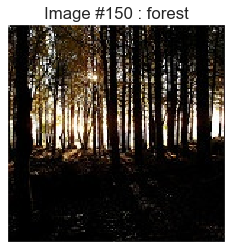

In [0]:
# Below we used VGG16 to predict the categories of 5 random images
# The 1st prediction
predict_img(categories, test_images, pred_labels)

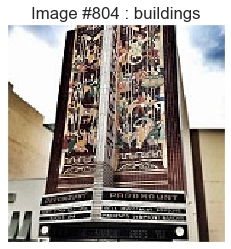

In [0]:
# The 2nd prediction
predict_img(categories, test_images, pred_labels)

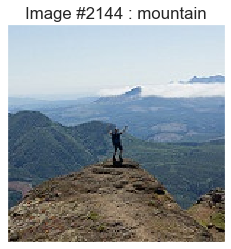

In [0]:
# The 3rd prediction
predict_img(categories, test_images, pred_labels)

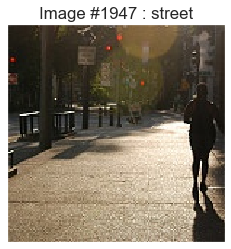

In [0]:
# The 4th prediction
predict_img(categories, test_images, pred_labels)

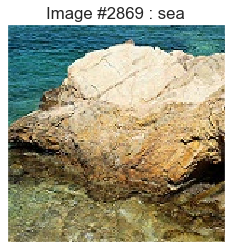

In [0]:
# The 5th prediction
predict_img(categories, test_images, pred_labels)

The VGG16 model predicted the categories of all 5 random images correctly.

# 3. Summary and Conclusion

In [0]:
import pandas as pd
index = ['Model 1 (Grayscale)', 'Model 2 (Grayscale)', 'Model 3 (Grayscale)', 'Model 4 (RGB)', 'Model 5 (RGB)', 'Model 6 (RGB)', 'Model 7 (RGB)', 'Model 8 (RGB)']
val_acc = [0.3744,0.4313,0.7676,  0.5116  ,   0.6462 ,  0.7674 , 0.7895, 0.8523 ]
val_loss = [1.5436,1.4740,0.7927,  1.2585  ,  0.9429  ,  1.0800 ,  1.0316, 0.4205]
test_acc = [0.3733,0.4350,0.7647,  0.5047  ,  0.6420  ,  0.747 , 0.777,  0.8523 ]
test_loss = [1.5385,1.4688,0.8347,  1.3140  ,  0.9507  ,  0.949  , 1.03 , 0.4205 ]

In [0]:
summary = pd.DataFrame(
    {'Model': index,
     'Validation Accuracy': val_acc,
     'Validation Loss': val_loss,
     'Test Accuracy': test_acc,
     'Test Loss': test_loss
    })
# summary.set_index('Model', inplace=True)
summary

,Model,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
0,Model 1 (Grayscale),0.3744,1.5436,0.3733,1.5385
1,Model 2 (Grayscale),0.4313,1.4740,0.4350,1.4688
2,Model 3 (Grayscale),0.7676,0.7927,0.7647,0.8347
3,Model 4 (RGB),0.5116,1.2585,0.5047,1.3140
4,Model 5 (RGB),0.6462,0.9429,0.6420,0.9507
5,Model 6 (RGB),0.7674,1.0800,0.7470,0.9490
6,Model 7 (RGB),0.7895,1.0316,0.7770,1.0300
7,Model 8 (RGB),0.8523,0.4205,0.8523,0.4205


Based on the results of all the Neural Networks we applied on image data set, the model that gave us the best result turns out to be VGG-16 with Test Accuracy of 0.8523.

# 4. Reference List 

Bansal, P. (2019, January 30). Intel Image Classification. Retrieved May 1, 2020, from https://www.kaggle.com/puneet6060/intel-image-classification

Carrington, D. (2020, February 7). How Many Photos Will Be Taken in 2020? Retrieved April 25, 2020, from https://focus.mylio.com/tech-today/how-many-photos-will-be-taken-in-2020